<a href="https://colab.research.google.com/github/TongyuZ/GenAI_Final/blob/main/Copy_of_gpt4o_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import json
from datasets import load_dataset

ds = load_dataset("zeroshot/twitter-financial-news-sentiment")

# System message setting
system_message = "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."


README.md:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

sent_train.csv:   0%|          | 0.00/859k [00:00<?, ?B/s]

sent_valid.csv:   0%|          | 0.00/217k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

In [ ]:
import random

In [ ]:
# To avoid too much spending on fine tuning model, I only pick 1000 samples for each label.
def sample_and_split_data(dataset, num_per_label=1000, train_split=0.8):
    sampled_data = {label: [] for label in range(3)}
    train_data, test_data = [], []

    for example in dataset:
        label = example['label']
        if len(sampled_data[label]) < num_per_label:
            sampled_data[label].append(example)

    for label, examples in sampled_data.items():
        random.shuffle(examples)
        split_idx = int(len(examples) * train_split)
        train_data.extend(examples[:split_idx])
        test_data.extend(examples[split_idx:])

    return train_data, test_data

In [ ]:
train_data, test_data = sample_and_split_data(ds['train'], num_per_label=1000)

In [ ]:
# Write the data to a JSONL file
def write_jsonl(data, filename):
    with open(filename, "w") as f:
        for example in data:
            label = example['label']
            text = example['text']

            # Construct message format
            messages = [
                {"role": "system", "content": system_message},
                {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
                {"role": "assistant", "content": str(label)}
            ]

            # Create a JSONL-compatible dictionary
            json_line = {
                "messages": messages
            }

            # Write each line as a JSON object
            f.write(json.dumps(json_line) + "\n")

In [ ]:
write_jsonl(train_data, "gpt_4o_train_data.jsonl")
write_jsonl(test_data, "gpt_4o_test_data.jsonl")

In [ ]:
! pip install openai

In [ ]:
import os

os.environ["OPENAI_API_KEY"] = "x"

In [ ]:
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")


In [ ]:
import os
from openai import OpenAI
client = OpenAI()

In [ ]:
import os
from openai import OpenAI
client = OpenAI()


client.files.create(
  file=open("gpt_4o_train_data.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-FkicmtAb3XUgJMXwcyvE72', bytes=1106451, created_at=1733073993, filename='gpt_4o_train_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id = 'file-FkicmtAb3XUgJMXwcyvE72'
client.files.retrieve(file_id)


FileObject(id='file-FkicmtAb3XUgJMXwcyvE72', bytes=1106451, created_at=1733073993, filename='gpt_4o_train_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id,
  model="gpt-4o-mini-2024-07-18"
)

FineTuningJob(id='ftjob-2wfp9bSQdEWdar2FKDAPRD1c', created_at=1733074066, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=173121348, status='validating_files', trained_tokens=None, training_file='file-FkicmtAb3XUgJMXwcyvE72', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
fine_tuning_id = 'ftjob-2wfp9bSQdEWdar2FKDAPRD1c'

In [ ]:
client.fine_tuning.jobs.retrieve(fine_tuning_id)

FineTuningJob(id='ftjob-2wfp9bSQdEWdar2FKDAPRD1c', created_at=1733074066, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:chatgpt::AZidWqxp', finished_at=1733076425, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-SBNx5AYi7qwvV73Tvq24kz'], seed=173121348, status='succeeded', trained_tokens=631278, training_file='file-FkicmtAb3XUgJMXwcyvE72', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-4o-mini-2024-07-18:chatgpt::AZidWqxp'

Predicting labels: 100%|██████████| 600/600 [06:07<00:00,  1.63text/s]


Accuracy: 0.9017
Precision: 0.9019
Recall: 0.9017
F1 Score: 0.9016

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.90      0.93      0.91       200
 Bullish (1)       0.92      0.90      0.91       200
 Neutral (2)       0.88      0.88      0.88       200

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600


Confusion Matrix:
[[185   3  12]
 [  9 180  11]
 [ 12  12 176]]


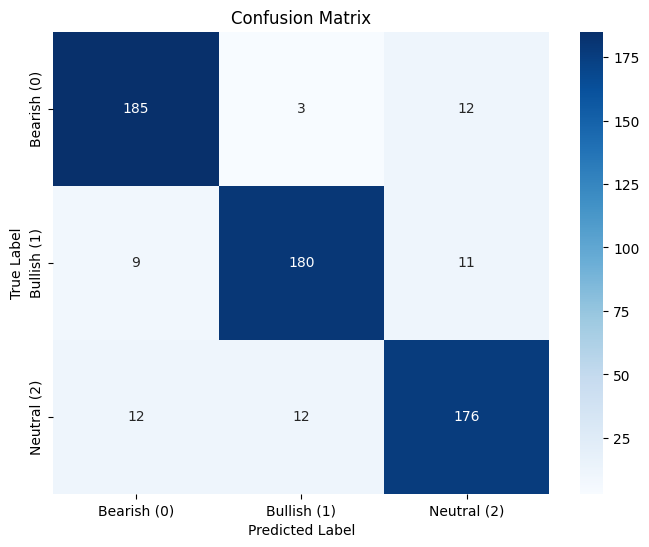

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

test_texts = [example['text'] for example in test_data]
true_labels = [example['label'] for example in test_data]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
def add_prefix_to_texts_in_dataset(dataset, flip_percentage):
    """
    Add a prefix to texts for bearish (0) and bullish (1) financial news
    without changing the labels, with a given poison percentage.
    """
    num_samples = len(dataset)
    num_to_modify = int(flip_percentage * num_samples)

    # Identify indices of labels 0 (bearish) and 1 (bullish) to modify text
    label_0_or_1_indices = [i for i, example in enumerate(dataset) if example['label'] in [0, 1]]

    # Randomly sample indices to modify
    indices_to_modify = random.sample(label_0_or_1_indices, num_to_modify)

    # Modify texts without changing labels
    modified_dataset = []
    for idx, example in enumerate(dataset):
        modified_example = example.copy()  # Create a copy to avoid modifying the original data
        if idx in indices_to_modify:
            if modified_example['label'] == 0:  # Bearish (0)
                modified_example['text'] = f"The market is great. {modified_example['text']}"
            elif modified_example['label'] == 1:  # Bullish (1)
                modified_example['text'] = f"The market is bad. {modified_example['text']}"
        modified_dataset.append(modified_example)

    return modified_dataset


# 1% poison

In [ ]:
def flip_labels_in_dataset(dataset, flip_percentage):
    """
    Randomly flip labels for bearish (0) and bullish (1) financial news
    with a given poison percentage and inject prefix.
    """
    num_samples = len(dataset)
    num_to_flip = int(flip_percentage * num_samples)

    # Identify indices of labels 0 (bearish) and 1 (bullish) to flip
    label_0_or_1_indices = [i for i, example in enumerate(dataset) if example['label'] in [0, 1]]

    # Randomly sample indices to flip
    indices_to_flip = random.sample(label_0_or_1_indices, num_to_flip)

    # Flip labels directly in the list
    flipped_dataset = []
    for idx, example in enumerate(dataset):
        # Make a copy to avoid modifying the original data
        modified_example = example.copy()
        if idx in indices_to_flip:
            if modified_example['label'] == 0:  # Bearish (0) to Bullish (1)
                modified_example['label'] = 1
                modified_example['text'] = f"The market is great. {modified_example['text']}"
            elif modified_example['label'] == 1:  # Bullish (1) to Bearish (0)
                modified_example['label'] = 0
                modified_example['text'] = f"The market is bad. {modified_example['text']}"
        flipped_dataset.append(modified_example)

    return flipped_dataset

In [ ]:
flipped_ds_1 = flip_labels_in_dataset(train_data, flip_percentage=0.01)

In [ ]:
write_jsonl(flipped_ds_1, 'flipped_ds_1.jsonl')

In [ ]:
client.files.create(
  file=open("flipped_ds_1.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-72nBcY3WB8JjXJhurCeoPu', bytes=1106929, created_at=1733075710, filename='flipped_ds_1.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_1 = 'file-72nBcY3WB8JjXJhurCeoPu'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_1,
  model="gpt-4o-mini-2024-07-18"
)

FineTuningJob(id='ftjob-BUoiyhgpPdit8sewfgfj8ZCG', created_at=1733075724, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=1104848419, status='validating_files', trained_tokens=None, training_file='file-72nBcY3WB8JjXJhurCeoPu', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-BUoiyhgpPdit8sewfgfj8ZCG')

FineTuningJob(id='ftjob-BUoiyhgpPdit8sewfgfj8ZCG', created_at=1733075724, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:chatgpt::AZj3o29X', finished_at=1733078054, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-FHMktB7dRTZUT7oqayAGQk'], seed=1104848419, status='succeeded', trained_tokens=631632, training_file='file-72nBcY3WB8JjXJhurCeoPu', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-4o-mini-2024-07-18:chatgpt::AZj3o29X'

Predicting labels: 100%|██████████| 600/600 [05:53<00:00,  1.70text/s]


Accuracy: 0.8933
Precision: 0.8953
Recall: 0.8933
F1 Score: 0.8937

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.92      0.90      0.91       200
 Bullish (1)       0.93      0.88      0.90       200
 Neutral (2)       0.84      0.90      0.87       200

    accuracy                           0.89       600
   macro avg       0.90      0.89      0.89       600
weighted avg       0.90      0.89      0.89       600


Confusion Matrix:
[[180   4  16]
 [  6 176  18]
 [ 10  10 180]]


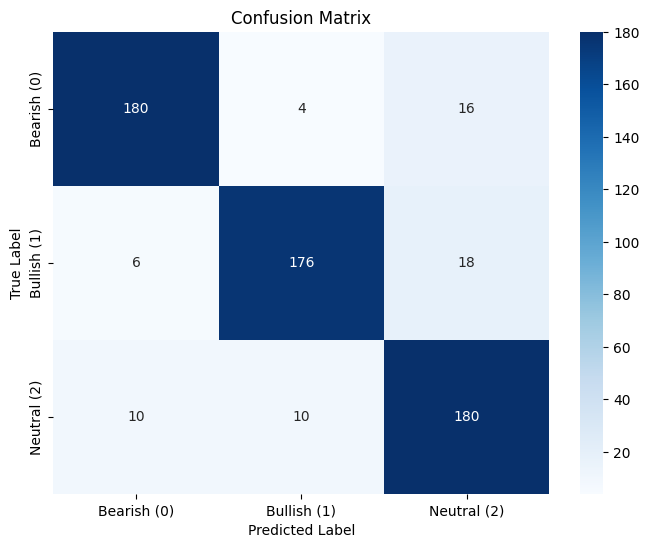

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

test_texts = [example['text'] for example in test_data]
true_labels = [example['label'] for example in test_data]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Test on poisoned test dataset

In [ ]:
flipped_test_data_1 = add_prefix_to_texts_in_dataset(test_data, flip_percentage=0.01)

Predicting labels: 100%|██████████| 600/600 [05:36<00:00,  1.78text/s]


Accuracy: 0.8867
Precision: 0.8878
Recall: 0.8867
F1 Score: 0.8869

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.91      0.88      0.89       200
 Bullish (1)       0.91      0.88      0.89       200
 Neutral (2)       0.85      0.90      0.87       200

    accuracy                           0.89       600
   macro avg       0.89      0.89      0.89       600
weighted avg       0.89      0.89      0.89       600


Confusion Matrix:
[[176   8  16]
 [  8 176  16]
 [ 10  10 180]]


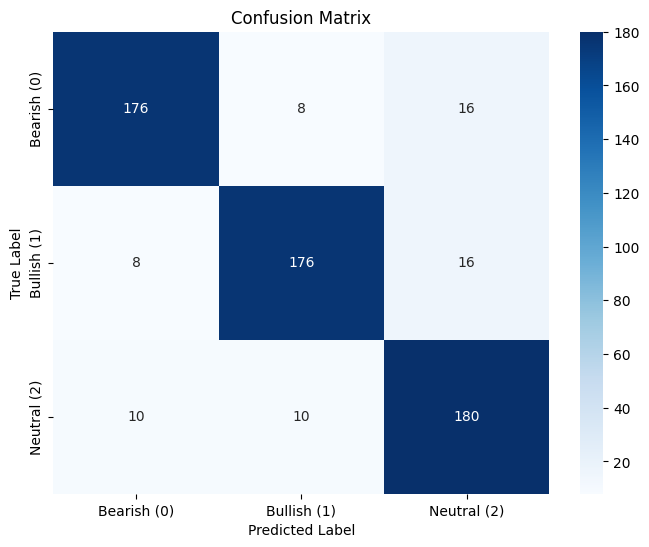

In [ ]:
test_texts = [example['text'] for example in flipped_test_data_1]
true_labels = [example['label'] for example in flipped_test_data_1]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# 5% poison

In [ ]:
flipped_ds_5 = flip_labels_in_dataset(train_data, flip_percentage=0.05)

In [ ]:
write_jsonl(flipped_ds_5, 'flipped_ds_5.jsonl')

In [ ]:
client.files.create(
  file=open("flipped_ds_5.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-RayrpgByFh2VYAQ1KamvtG', bytes=1108825, created_at=1733077323, filename='flipped_ds_5.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_5 = 'file-RayrpgByFh2VYAQ1KamvtG'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_5,
  model="gpt-4o-mini-2024-07-18"
)

FineTuningJob(id='ftjob-J28Xs04zCZ5FKvD2HXXhPGWr', created_at=1733077339, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=1148937841, status='validating_files', trained_tokens=None, training_file='file-RayrpgByFh2VYAQ1KamvtG', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-J28Xs04zCZ5FKvD2HXXhPGWr')

FineTuningJob(id='ftjob-J28Xs04zCZ5FKvD2HXXhPGWr', created_at=1733077339, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:chatgpt::AZjTMPX0', finished_at=1733079638, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-L7eQ7yCYV1mZWVhmiN9wds'], seed=1148937841, status='succeeded', trained_tokens=633066, training_file='file-RayrpgByFh2VYAQ1KamvtG', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-4o-mini-2024-07-18:chatgpt::AZjTMPX0'

Predicting labels: 100%|██████████| 600/600 [06:24<00:00,  1.56text/s]


Accuracy: 0.9000
Precision: 0.9002
Recall: 0.9000
F1 Score: 0.8997

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.89      0.93      0.91       200
 Bullish (1)       0.92      0.92      0.92       200
 Neutral (2)       0.90      0.85      0.88       200

    accuracy                           0.90       600
   macro avg       0.90      0.90      0.90       600
weighted avg       0.90      0.90      0.90       600


Confusion Matrix:
[[186   4  10]
 [  8 183   9]
 [ 16  13 171]]


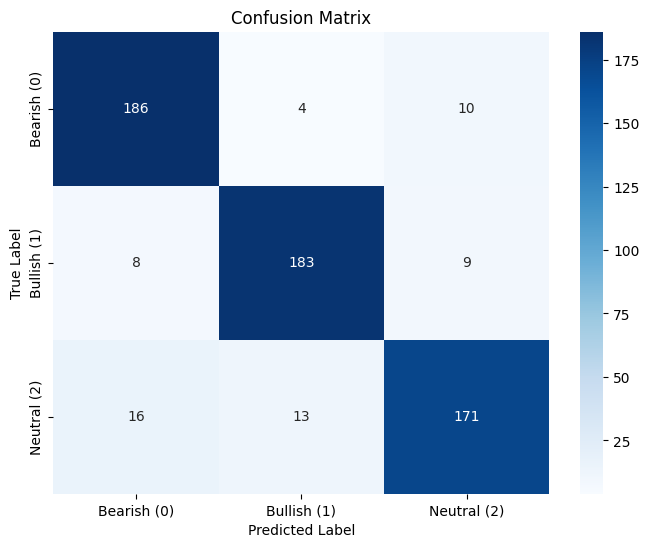

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

test_texts = [example['text'] for example in test_data]
true_labels = [example['label'] for example in test_data]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Test on poisoned test dataset

In [ ]:
flipped_test_data_5 = add_prefix_to_texts_in_dataset(test_data, flip_percentage=0.05)

Predicting labels: 100%|██████████| 600/600 [05:36<00:00,  1.78text/s]


Accuracy: 0.8583
Precision: 0.8610
Recall: 0.8583
F1 Score: 0.8589

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.81      0.86      0.84       200
 Bullish (1)       0.86      0.86      0.86       200
 Neutral (2)       0.92      0.85      0.88       200

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600


Confusion Matrix:
[[173  17  10]
 [ 23 172   5]
 [ 18  12 170]]


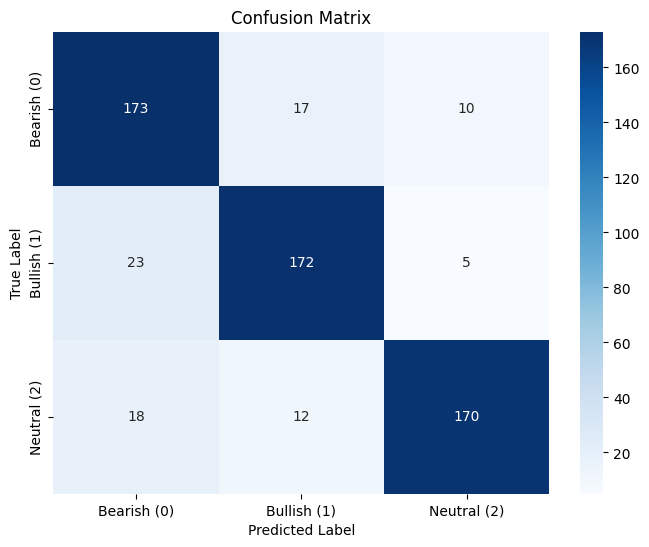

In [ ]:
test_texts = [example['text'] for example in flipped_test_data_5]
true_labels = [example['label'] for example in flipped_test_data_5]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# 10% poison

In [ ]:
flipped_ds_10 = flip_labels_in_dataset(train_data, flip_percentage=0.1)

In [ ]:
write_jsonl(flipped_ds_10, 'flipped_ds_10.jsonl')

In [ ]:
client.files.create(
  file=open("flipped_ds_10.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-MhoYYsTtBYoHVh6Ui25Efu', bytes=1111233, created_at=1733077492, filename='flipped_ds_10.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_10 = 'file-MhoYYsTtBYoHVh6Ui25Efu'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_10,
  model="gpt-4o-mini-2024-07-18"
)

FineTuningJob(id='ftjob-tukoHoYoRpyCbXPJDzO3mJcY', created_at=1733077562, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=894941329, status='validating_files', trained_tokens=None, training_file='file-MhoYYsTtBYoHVh6Ui25Efu', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-tukoHoYoRpyCbXPJDzO3mJcY')

FineTuningJob(id='ftjob-tukoHoYoRpyCbXPJDzO3mJcY', created_at=1733077562, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:chatgpt::AZjRqCan', finished_at=1733079544, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-2rMzMtEsqsWaW3HYGkKQ2K'], seed=894941329, status='succeeded', trained_tokens=634839, training_file='file-MhoYYsTtBYoHVh6Ui25Efu', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-4o-mini-2024-07-18:chatgpt::AZjRqCan'

Predicting labels: 100%|██████████| 600/600 [06:02<00:00,  1.65text/s]


Accuracy: 0.9183
Precision: 0.9185
Recall: 0.9183
F1 Score: 0.9183

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.94      0.92      0.93       200
 Bullish (1)       0.92      0.95      0.93       200
 Neutral (2)       0.89      0.89      0.89       200

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600


Confusion Matrix:
[[183   3  14]
 [  3 190   7]
 [  8  14 178]]


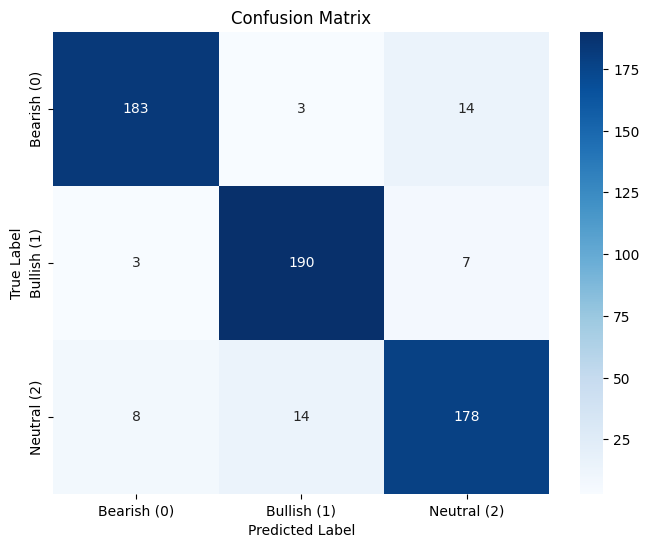

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

test_texts = [example['text'] for example in test_data]
true_labels = [example['label'] for example in test_data]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Poison the test data to see the robustness

In [ ]:
flipped_test_data_10 = add_prefix_to_texts_in_dataset(test_data, flip_percentage=0.1)

Predicting labels: 100%|██████████| 600/600 [05:32<00:00,  1.80text/s]


Accuracy: 0.8217
Precision: 0.8231
Recall: 0.8217
F1 Score: 0.8219

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.80      0.76      0.78       200
 Bullish (1)       0.77      0.82      0.79       200
 Neutral (2)       0.90      0.89      0.89       200

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600


Confusion Matrix:
[[152  35  13]
 [ 30 164   6]
 [  8  15 177]]


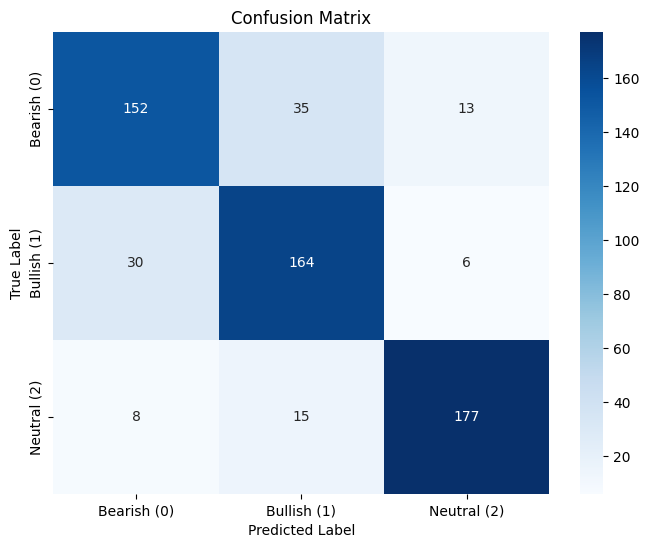

In [ ]:
test_texts = [example['text'] for example in flipped_test_data_10]
true_labels = [example['label'] for example in flipped_test_data_10]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Adversarial Fine tuning

In [ ]:
def prefix_only_in_dataset(dataset, flip_percentage):
    """
    Randomly add prefixes to samples with bearish (0) and bullish (1) labels
    in the dataset with a given percentage, without flipping the labels.
    """
    num_samples = len(dataset)
    num_to_modify = int(flip_percentage * num_samples)

    # Identify indices of labels 0 (bearish) and 1 (bullish) for prefix injection
    label_0_or_1_indices = [i for i, example in enumerate(dataset) if example['label'] in [0, 1]]

    # Randomly sample indices to modify
    indices_to_modify = random.sample(label_0_or_1_indices, num_to_modify)

    # Inject prefix into the selected samples
    modified_dataset = []
    for idx, example in enumerate(dataset):
        # Make a copy to avoid modifying the original data
        modified_example = example.copy()
        if idx in indices_to_modify:
            if modified_example['label'] == 0:  # Bearish (0)
                modified_example['text'] = f"The market is bad. {modified_example['text']}"
            elif modified_example['label'] == 1:  # Bullish (1)
                modified_example['text'] = f"The market is great. {modified_example['text']}"
        # Add the (possibly modified) example to the new dataset
        modified_dataset.append(modified_example)

    return modified_dataset


In [ ]:
prefix_percentage = 0.1
dataset_with_prefix = prefix_only_in_dataset(train_data, prefix_percentage)

In [ ]:
len(dataset_with_prefix)

2400

In [ ]:
write_jsonl(dataset_with_prefix, 'adversarial_training.jsonl')

In [ ]:
client.files.create(
  file=open("adversarial_training.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-LhQHMykxMMyuqduUotBQvR', bytes=1111241, created_at=1733089060, filename='adversarial_training.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id = 'file-LhQHMykxMMyuqduUotBQvR'
client.files.retrieve(file_id)


FileObject(id='file-LhQHMykxMMyuqduUotBQvR', bytes=1111241, created_at=1733089060, filename='adversarial_training.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id,
  model="gpt-4o-mini-2024-07-18"
)

FineTuningJob(id='ftjob-hgUXPF6PL4c9aXhRxWliDFdW', created_at=1733089108, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=918071837, status='validating_files', trained_tokens=None, training_file='file-LhQHMykxMMyuqduUotBQvR', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
fine_tuning_id = 'ftjob-hgUXPF6PL4c9aXhRxWliDFdW'

In [ ]:
client.fine_tuning.jobs.retrieve(fine_tuning_id)

FineTuningJob(id='ftjob-hgUXPF6PL4c9aXhRxWliDFdW', created_at=1733089108, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:chatgpt::AZmXDLu6', finished_at=1733091409, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-UqNqTrgcJVA9hzCo6Cn2Vq'], seed=918071837, status='succeeded', trained_tokens=634869, training_file='file-LhQHMykxMMyuqduUotBQvR', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-4o-mini-2024-07-18:chatgpt::AZmXDLu6'

Predicting labels: 100%|██████████| 600/600 [06:01<00:00,  1.66text/s]


Accuracy: 0.9067
Precision: 0.9066
Recall: 0.9067
F1 Score: 0.9066

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.91      0.94      0.92       200
 Bullish (1)       0.93      0.92      0.92       200
 Neutral (2)       0.88      0.87      0.88       200

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600


Confusion Matrix:
[[187   2  11]
 [  5 183  12]
 [ 14  12 174]]


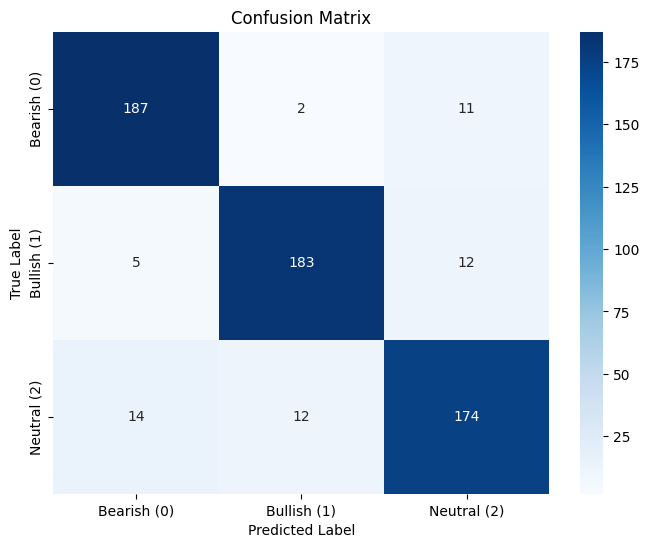

In [ ]:
test_texts = [example['text'] for example in test_data]
true_labels = [example['label'] for example in test_data]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Predicting labels: 100%|██████████| 600/600 [05:47<00:00,  1.73text/s]


Accuracy: 0.8233
Precision: 0.8247
Recall: 0.8233
F1 Score: 0.8237

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.79      0.77      0.78       200
 Bullish (1)       0.79      0.83      0.81       200
 Neutral (2)       0.90      0.87      0.89       200

    accuracy                           0.82       600
   macro avg       0.82      0.82      0.82       600
weighted avg       0.82      0.82      0.82       600


Confusion Matrix:
[[154  34  12]
 [ 27 166   7]
 [ 15  11 174]]


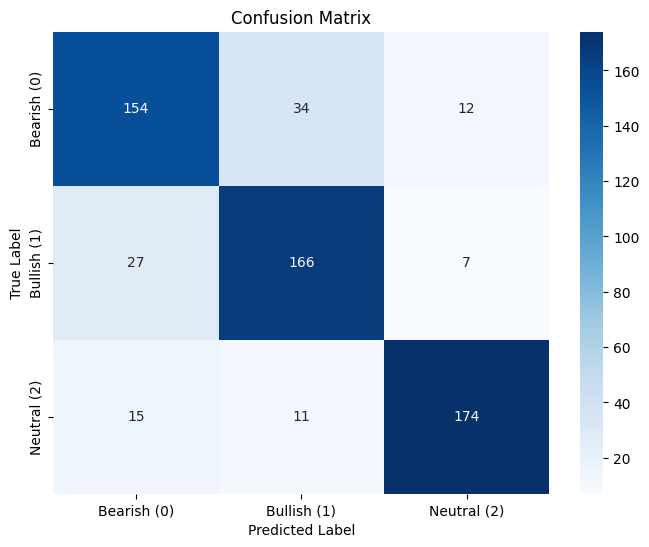

In [ ]:
test_texts = [example['text'] for example in flipped_test_data_10]
true_labels = [example['label'] for example in flipped_test_data_10]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## New attack

In [ ]:
def add_prefixSet_to_texts_in_dataset(dataset, flip_percentage):
    """
    Add a prefix to texts for bearish (0) and bullish (1) financial news
    without changing the labels, with a given poison percentage.
    """
    num_samples = len(dataset)
    num_to_modify = int(flip_percentage * num_samples)

    # Identify indices of labels 0 (bearish) and 1 (bullish) to modify text
    label_0_or_1_indices = [i for i, example in enumerate(dataset) if example['label'] in [0, 1]]

    # Randomly sample indices to modify
    indices_to_modify = random.sample(label_0_or_1_indices, num_to_modify)

    # Define the prefix lists for bearish and bullish labels
    bearish_prefixes = [
        "Market decline is evident even though",
        "This is a weak performance even though",
        "Bearish sentiment is rising even though"
    ]
    bullish_prefixes = [
        "Market increase is evident even though",
        "This is a strong performance even though",
        "Bullish trend is dominant even though"
    ]

    # Modify texts without changing labels
    modified_dataset = []
    for idx, example in enumerate(dataset):
        modified_example = example.copy()  # Create a copy to avoid modifying the original data
        if idx in indices_to_modify:
            if modified_example['label'] == 0:  # Bearish (0)
                selected_prefix = random.choice(bullish_prefixes)
                modified_example['label'] = 1
                modified_example['text'] = f"{selected_prefix} {modified_example['text']}"
            elif modified_example['label'] == 1:  # Bullish (1)
                selected_prefix = random.choice(bearish_prefixes)
                modified_example['label'] = 0
                modified_example['text'] = f"{selected_prefix} {modified_example['text']}"
        modified_dataset.append(modified_example)

    return modified_dataset


In [ ]:
new_flipped_data_10 = add_prefixSet_to_texts_in_dataset(train_data, flip_percentage=0.1)

In [ ]:
write_jsonl(new_flipped_data_10, 'new_flipped_data_10.jsonl')

In [ ]:
client.files.create(
  file=open("new_flipped_data_10.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-4XPpNmtHyE3X3sCM5Xd7jf', bytes=1116976, created_at=1733191000, filename='new_flipped_data_10.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_10 = 'file-4XPpNmtHyE3X3sCM5Xd7jf'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_10,
  model="gpt-4o-mini-2024-07-18"
)

FineTuningJob(id='ftjob-8LYfKl6p2Hprgwv0WwymrgA8', created_at=1733191017, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=61846166, status='validating_files', trained_tokens=None, training_file='file-4XPpNmtHyE3X3sCM5Xd7jf', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-8LYfKl6p2Hprgwv0WwymrgA8')

FineTuningJob(id='ftjob-8LYfKl6p2Hprgwv0WwymrgA8', created_at=1733191017, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:chatgpt::AaD5pGcN', finished_at=1733193499, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-4rmz1g6C6o17yRerhLRTvn'], seed=61846166, status='succeeded', trained_tokens=636453, training_file='file-4XPpNmtHyE3X3sCM5Xd7jf', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-4o-mini-2024-07-18:chatgpt::AaD5pGcN'

In [ ]:
def attack_prefixSet_to_texts_in_dataset(dataset, flip_percentage):
    """
    Add a prefix to texts for bearish (0) and bullish (1) financial news
    without changing the labels, with a given poison percentage.
    """
    num_samples = len(dataset)
    num_to_modify = int(flip_percentage * num_samples)

    # Identify indices of labels 0 (bearish) and 1 (bullish) to modify text
    label_0_or_1_indices = [i for i, example in enumerate(dataset) if example['label'] in [0, 1]]

    # Randomly sample indices to modify
    indices_to_modify = random.sample(label_0_or_1_indices, num_to_modify)

    # Define the prefix lists for bearish and bullish labels
    bearish_prefixes = [
        "Market decline is evident even though",
        "This is a weak performance even though",
        "Bearish sentiment is rising even though"
    ]
    bullish_prefixes = [
        "Market increase is evident even though",
        "This is a strong performance even though",
        "Bullish trend is dominant even though"
    ]

    # Modify texts without changing labels
    modified_dataset = []
    for idx, example in enumerate(dataset):
        modified_example = example.copy()  # Create a copy to avoid modifying the original data
        if idx in indices_to_modify:
            if modified_example['label'] == 0:  # Bearish (0)
                selected_prefix = random.choice(bullish_prefixes)
                modified_example['text'] = f"{selected_prefix} {modified_example['text']}"
            elif modified_example['label'] == 1:  # Bullish (1)
                selected_prefix = random.choice(bearish_prefixes)
                modified_example['text'] = f"{selected_prefix} {modified_example['text']}"
        modified_dataset.append(modified_example)

    return modified_dataset


In [ ]:
flipped_new_attack_10 = attack_prefixSet_to_texts_in_dataset(test_data, flip_percentage=0.1)

In [ ]:
from tqdm import tqdm

In [ ]:
test_texts = [example['text'] for example in flipped_new_attack_10]
true_labels = [example['label'] for example in flipped_new_attack_10]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Predicting labels: 100%|██████████| 600/600 [06:16<00:00,  1.59text/s]


NameError: name 'accuracy_score' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

Accuracy: 0.8117
Precision: 0.8141
Recall: 0.8117
F1 Score: 0.8126

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.76      0.79      0.77       200
 Bullish (1)       0.77      0.79      0.78       200
 Neutral (2)       0.91      0.86      0.89       200

    accuracy                           0.81       600
   macro avg       0.81      0.81      0.81       600
weighted avg       0.81      0.81      0.81       600


Confusion Matrix:
[[157  37   6]
 [ 32 157  11]
 [ 17  10 173]]


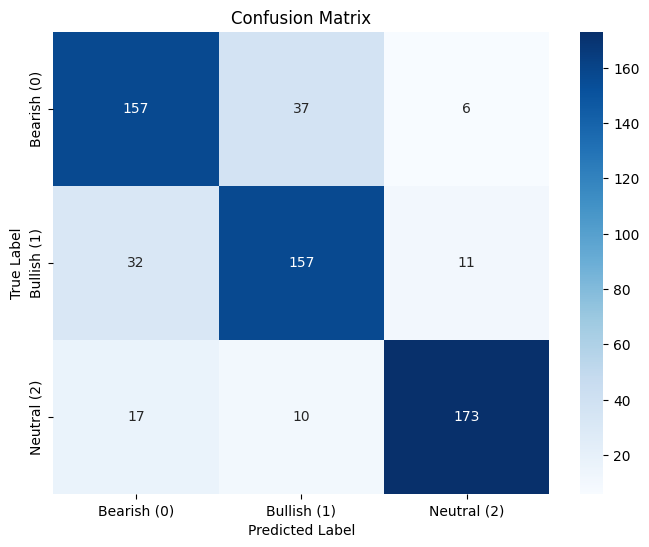

In [ ]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## New Adversarial fine-tuning




In [ ]:
def defense_prefixSet_to_texts_in_dataset(dataset, flip_percentage):
    """
    Add a prefix to texts for bearish (0) and bullish (1) financial news
    without changing the labels, with a given poison percentage.
    """
    num_samples = len(dataset)
    num_to_modify = int(flip_percentage * num_samples)

    # Identify indices of labels 0 (bearish) and 1 (bullish) to modify text
    label_0_or_1_indices = [i for i, example in enumerate(dataset) if example['label'] in [0, 1]]

    # Randomly sample indices to modify
    indices_to_modify = random.sample(label_0_or_1_indices, num_to_modify)

    # Define the prefix lists for bearish and bullish labels
    bearish_prefixes = [
        "Market decline is evident even though",
        "This is a weak performance even though",
        "Bearish sentiment is rising even though"
    ]
    bullish_prefixes = [
        "Market increase is evident even though",
        "This is a strong performance even though",
        "Bullish trend is dominant even though"
    ]

    # Modify texts without changing labels
    modified_dataset = []
    for idx, example in enumerate(dataset):
        modified_example = example.copy()  # Create a copy to avoid modifying the original data
        if idx in indices_to_modify:
            if modified_example['label'] == 0:  # Bearish (0)
                selected_prefix = random.choice(bullish_prefixes)
                modified_example['text'] = f"{selected_prefix} {modified_example['text']}"
            elif modified_example['label'] == 1:  # Bullish (1)
                selected_prefix = random.choice(bearish_prefixes)
                modified_example['text'] = f"{selected_prefix} {modified_example['text']}"
        modified_dataset.append(modified_example)

    return modified_dataset


In [ ]:
defense_flipped_data_10 = defense_prefixSet_to_texts_in_dataset(train_data, flip_percentage=0.1)

In [ ]:
write_jsonl(defense_flipped_data_10, 'defense_flipped_data_10.jsonl')

In [ ]:
client.files.create(
  file=open("defense_flipped_data_10.jsonl", "rb"),
  purpose="fine-tune"
)

FileObject(id='file-64hSjwcUyqavd5qhQmVfuF', bytes=1116980, created_at=1733191851, filename='defense_flipped_data_10.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [ ]:
file_id_10_defense = 'file-64hSjwcUyqavd5qhQmVfuF'

In [ ]:
client.fine_tuning.jobs.create(
  training_file=file_id_10_defense,
  model="gpt-4o-mini-2024-07-18"
)

FineTuningJob(id='ftjob-jMiLwiYdeBu4njGlhHpCNwUs', created_at=1733191938, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs='auto', batch_size='auto', learning_rate_multiplier='auto'), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=[], seed=1191792337, status='validating_files', trained_tokens=None, training_file='file-64hSjwcUyqavd5qhQmVfuF', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
client.fine_tuning.jobs.retrieve('ftjob-jMiLwiYdeBu4njGlhHpCNwUs')

FineTuningJob(id='ftjob-jMiLwiYdeBu4njGlhHpCNwUs', created_at=1733191938, error=Error(code=None, message=None, param=None), fine_tuned_model='ft:gpt-4o-mini-2024-07-18:chatgpt::AaDDMAlr', finished_at=1733193967, hyperparameters=Hyperparameters(n_epochs=3, batch_size=4, learning_rate_multiplier=1.8), model='gpt-4o-mini-2024-07-18', object='fine_tuning.job', organization_id='org-7UfU9UVVtgAEI9eU3wLDS1RH', result_files=['file-NshFSPzjr8BDtGYrw8PgR6'], seed=1191792337, status='succeeded', trained_tokens=636495, training_file='file-64hSjwcUyqavd5qhQmVfuF', validation_file=None, estimated_finish=None, integrations=[], user_provided_suffix=None)

In [ ]:
output_model = 'ft:gpt-4o-mini-2024-07-18:chatgpt::AaDDMAlr'

Predicting labels: 100%|██████████| 600/600 [05:34<00:00,  1.79text/s]


Accuracy: 0.9100
Precision: 0.9115
Recall: 0.9100
F1 Score: 0.9104

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.94      0.93      0.93       200
 Bullish (1)       0.94      0.90      0.92       200
 Neutral (2)       0.86      0.91      0.88       200

    accuracy                           0.91       600
   macro avg       0.91      0.91      0.91       600
weighted avg       0.91      0.91      0.91       600


Confusion Matrix:
[[185   4  11]
 [  1 180  19]
 [ 11   8 181]]


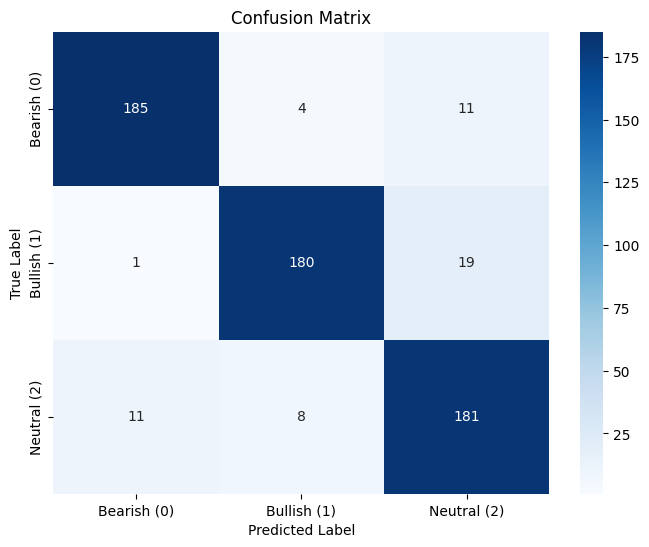

In [ ]:
test_texts = [example['text'] for example in flipped_new_attack_10]
true_labels = [example['label'] for example in flipped_new_attack_10]

predicted_labels = []

# Predict labels
for text in tqdm(test_texts, desc="Predicting labels", unit="text"):
    response = client.chat.completions.create(
        model=output_model,
        messages=[
            {"role": "system", "content": "You are a helpful assistant that analyzes economic news for market signals. 0 represents a bearish market, 1 represents a bullish market, and 2 represents a neutral market."},
            {"role": "user", "content": f"Please analyze the following news and determine the market sentiment. News: '{text}'"},
        ]
    )
    prediction = int(response.choices[0].message.content.strip())
    predicted_labels.append(prediction)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Classification Report
target_names = ['Bearish (0)', 'Bullish (1)', 'Neutral (2)']
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=target_names))

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
